# Assignment 2 (CISC 372)

The following is my second assignment for CISC 372.
## Properties of Image Classification

The following are the properties of image classification:

1. Some patterns are much smaller than the whole image.
2. The same patterns appear in different regions.
3. Subsampling the pixels will not change the object.

The way that image classification traverses is through the following model:

1. Image is fed through a convolution.
2. Max pooling.
3. Convolution.
4. Max pooling.
5. Flattened.
6. MLP, Softmax.


# Part 1: Image Classification using CNN

In this part, the creation of a basic CNN model that can identify an image is required.

The following are the 13 subcategories of images:
1. Topwear.
2. Bottomwear.
3. Innerwear.
4. Bags.
5. Watches.
6. Jewellery.
7. Eyewear.
8. Wallets.
9. Shoes.
10. Sandal.
11. Makeup.
12. Fragrance.
13. Others.

We are given a dataset of 44,441 fashion product images, and two files: ```train.csv```, and ```test.csv```. These both contain meta-data related to each image; ```image id```, ```label```, and ```productDisplayName```.

### Justifications Behind My Model

The following are the imports for the CNN:

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import os as operating_system
import missingno as msno
import csv
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import kagglehub

In [3]:
# Here I am downloading the dataset
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

# Here I am defining the working directory
working_directory = operating_system.getcwd()  # Gets the current working directory
destination = operating_system.path.join(working_directory, "fashion-product-images-small")

if operating_system.path.exists(path):
    operating_system.rename(path, destination)
    print(f"Dataset moved to working directory: {destination}")
else:
    print("Dataset not found at the expected location.")

100%|██████████| 565M/565M [00:03<00:00, 185MB/s]

Extracting files...


Dataset moved to working directory: /content/fashion-product-images-small


In [ ]:
def extract(csv_file=""):
    try:
        return pd.read_csv(csv_file, sep='\t')
    except FileNotFoundError:
        print(f"Error: {csv_file} not found.")
        return None

def load_dataframe(data, column_fields=None):
    if data is None:
        return None
    if column_fields is None:
        print("Warning: No columns specified. Returning full dataset.")
        return data
    return data[column_fields].dropna()

def dimension(dataframe):
    return dataframe.shape if dataframe is not None else (0, 0)

def load_dataset(csv_file, img_dir):
    df = extract(csv_file)
    if df is None:
        return None, None

    df.columns = ['imageid', 'label', 'productname']
    df = df.drop(index=0)

    # Convert to string and append ".jpg" 🔥 FIXED
    df['imageid'] = df['imageid'].astype(str) + ".jpg"
    df['label'] = df['label'].astype(str)

    return df, df['label'].unique().tolist()


train_df, label_to_index = load_dataset('train.csv', './images')
test_df, _ = load_dataset('test.csv', './images')

row_train, col_train = dimension(train_df)
row_test, col_test = dimension(test_df)

print(f'Dimensions of Training Dataset\nRows: {row_train}, Columns: {col_train}')
print(f'Dimensions of Testing Dataset\nRows: {row_test}, Columns: {col_test}')

IMG_HEIGHT, IMG_WIDTH = 80, 60
BATCH_SIZE = 150
EPOCHS = 3
NUM_CLASSES = len(label_to_index) if label_to_index else 0

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./fashion-product-images-small/images",  # 🔥 Corrected path
    x_col="imageid",
    y_col="label",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./fashion-product-images-small/images",  # 🔥 Corrected path
    x_col="imageid",
    y_col="label",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./fashion-product-images-small/images",  # 🔥 Corrected path
    x_col="imageid",
    y_col="label",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Define CNN model
def build_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Prevent overfitting
        layers.Dense(NUM_CLASSES, activation='softmax')  # Multi-class classification
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize model
if NUM_CLASSES > 0:
    model = build_model()
    model.summary()

    # Callbacks for training
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping, lr_scheduler]
    )

    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

    # Plot training history
    plot.plot(history.history['accuracy'], label='Train Accuracy')
    plot.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plot.xlabel('Epochs')
    plot.ylabel('Accuracy')
    plot.legend()
    plot.show()
else:
    print("Error: No classes detected. Check dataset loading.")


Dimensions of Training Dataset
Rows: 40440, Columns: 3
Dimensions of Testing Dataset
Rows: 3999, Columns: 3
Found 32352 validated image filenames belonging to 13 classes.
Found 8088 validated image filenames belonging to 13 classes.
Found 3999 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 78, 58, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 39, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 37, 27, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 18, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 8, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       1,310,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,407,565 (5.37 MB)

 Trainable params: 1,407,565 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
216/216 ━━━━━━━━━━━━━━━━━━━━ 80s 348ms/step - accuracy: 0.4599 - loss: 1.7010 - val_accuracy: 0.6721 - val_loss: 1.0032 - learning_rate: 0.0010
Epoch 2/3
128/216 ━━━━━━━━━━━━━━━━━━━━ 22s 260ms/step - accuracy: 0.6723 - loss: 1.0257

In [15]:
# Get true labels
true_labels = test_generator.classes

# Get predicted labels
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step
              precision    recall  f1-score   support

        Bags       0.88      0.80      0.84       266
  Bottomwear       0.92      0.88      0.90       225
     Eyewear       0.90      1.00      0.95       114
   Fragrance       0.61      0.23      0.34        99
   Innerwear       0.96      0.72      0.82       159
   Jewellery       0.76      0.63      0.69       106
      Makeup       0.00      0.00      0.00        37
      Others       0.72      0.66      0.69       549
      Sandal       0.00      0.00      0.00        79
       Shoes       0.78      0.99      0.87       668
     Topwear       0.92      0.98      0.95      1385
     Wallets       0.68      0.90      0.78        70
     Watches       0.87      0.93      0.90       242

    accuracy                           0.85      3999
   macro avg       0.69      0.67      0.67      3999
weighted avg       0.82      0.85      0.83      3999



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


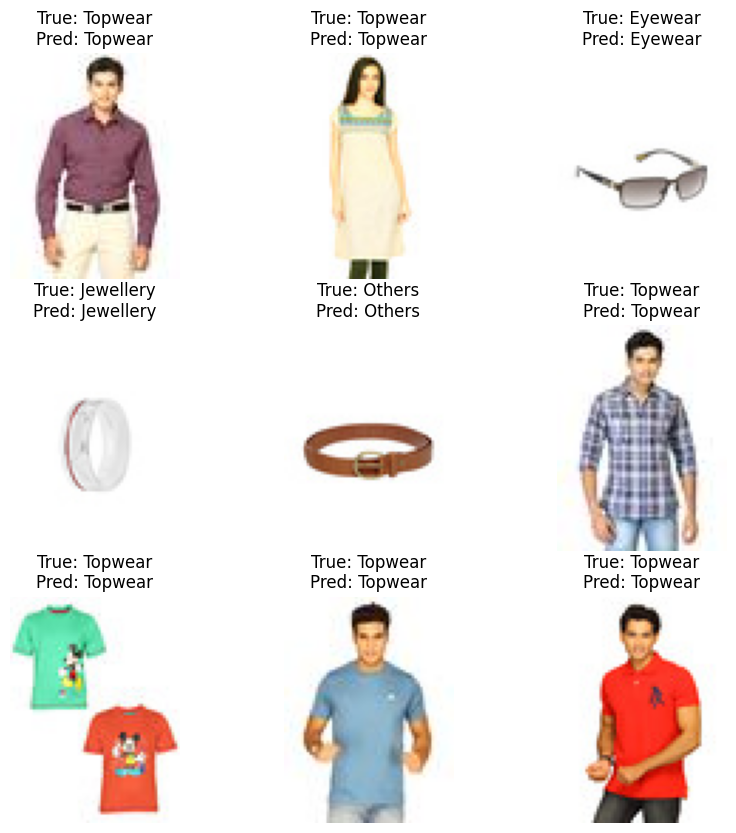

In [21]:
# Get a batch of test images and labels
test_images, test_labels = next(iter(test_generator))

# Predict labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Plot images with predicted & actual labels
fig, axes = plot.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i in range(9):
    img = test_images[i]
    true_label = class_names[np.argmax(test_labels[i])]
    pred_label = class_names[predicted_labels[i]]

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")

plot.show()
